In [1]:
from qiskit.compiler import transpile, schedule, assemble
import pickle
from qiskit import pulse, execute, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ
from qiskit.transpiler.passes.scheduling.calibration_creators import RZXCalibrationBuilder

In [2]:
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter, TomographyFitter
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info.operators.channel import Choi, Kraus, PTM
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate

from qiskit.visualization import(
  plot_state_city,
  plot_bloch_multivector,
  plot_state_paulivec,
  plot_state_hinton,
  plot_state_qsphere)

In [3]:
from qiskit.providers.aer.noise.errors.errorutils import standard_gate_unitary
from qiskit.quantum_info.operators.measures import process_fidelity
from qiskit.quantum_info import Choi, Kraus, Operator
import qiskit.quantum_info as qi

In [4]:
provider = IBMQ.load_account()

In [5]:
provider_pulse =IBMQ.get_provider(hub='ibm-q-startup', group='phasecraft-ltd', project='pulse-level-cont')

In [6]:
backend = provider_pulse.get_backend('ibmq_bogota')

config = backend.configuration()
props = backend.properties()
defaults = backend.defaults()

calibrations = defaults.instruction_schedule_map
basis_gates = config.basis_gates
inst_map = defaults.instruction_schedule_map

In [7]:
RZX_cals = RZXCalibrationBuilder(backend)

In [21]:
qubits = (1,2)
angles = [0.1, 0.5, 1.57]

In [31]:
schedules = {str(angle): RZX_cals.get_calibration([angle] , qubits) for angle in angles}

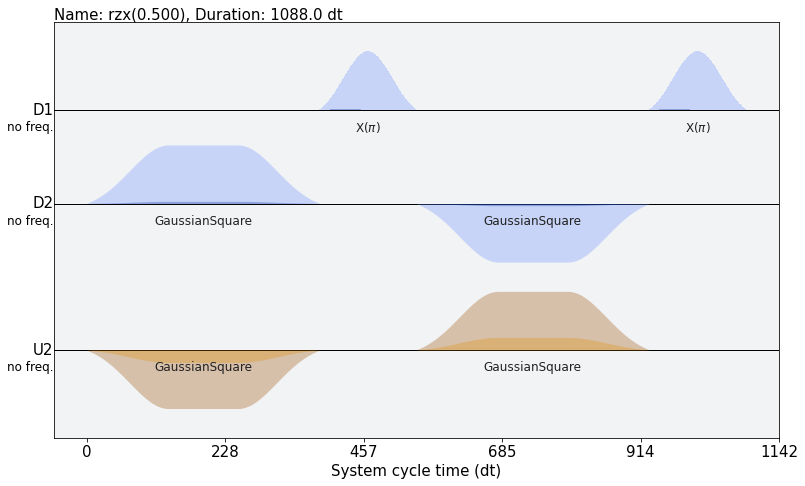

In [23]:
schedules['0.5'].draw()

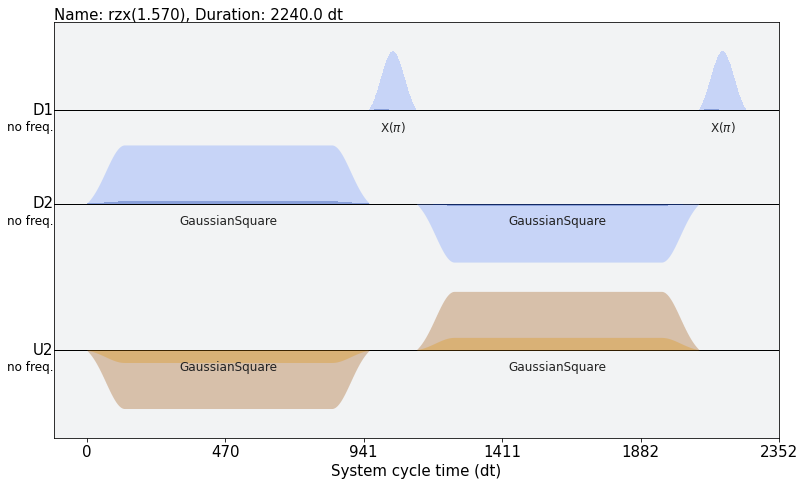

In [24]:
schedules['1.57'].draw()

In [27]:
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
  q1: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
  q2: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
  q3: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
  q4: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'rzx_0.1', 'cx', 'rzx_0.5', 'rzx_1.57'}
  (2, 1): {'cx'}
  (2, 3): {'cx'}
  (3, 2): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>


In [28]:
for angle in angles:
    gate_name = f'rzx_{angle}'
    basis_gates += [gate_name]
    inst_map.add(gate_name, qubits, schedules[str(angle)])

In [29]:
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
  q1: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
  q2: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
  q3: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
  q4: {'id', 'rz', 'x', 'measure', 'u3', 'sx', 'u1', 'u2'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'rzx_0.1', 'cx', 'rzx_0.5', 'rzx_1.57'}
  (2, 1): {'cx'}
  (2, 3): {'cx'}
  (3, 2): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>


In [32]:
gates = {str(angle): Gate(f'rzx_{angle}', 2, []) for angle in angles}

In [33]:
label = '19.May.bogota'
qpt_experiments = {}
qregs = QuantumRegister(config.n_qubits)

for angle in angles:
    
    gate = gates[str(angle)]
    circuit = QuantumCircuit(qregs)
    circuit.append(gate, qargs=[qregs[qubits[0]], qregs[qubits[1]]]) 
    
    qpt_circuits = process_tomography_circuits(circuit, [qregs[qubits[0]], qregs[qubits[1]]]) 
    qpt_circuits = transpile(qpt_circuits, backend, basis_gates)
    qpt_schedules = schedule(qpt_circuits, backend, inst_map)
    
    qpt_experiments[str(angle)] = {'transpiled_circuits': qpt_circuits, 'qpt_schedules': qpt_schedules}

/home/laura/.local/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:465: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += preparation(prep_label[j], prep_qubits[j])
/home/laura/.local/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/home/laura/.local/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep 

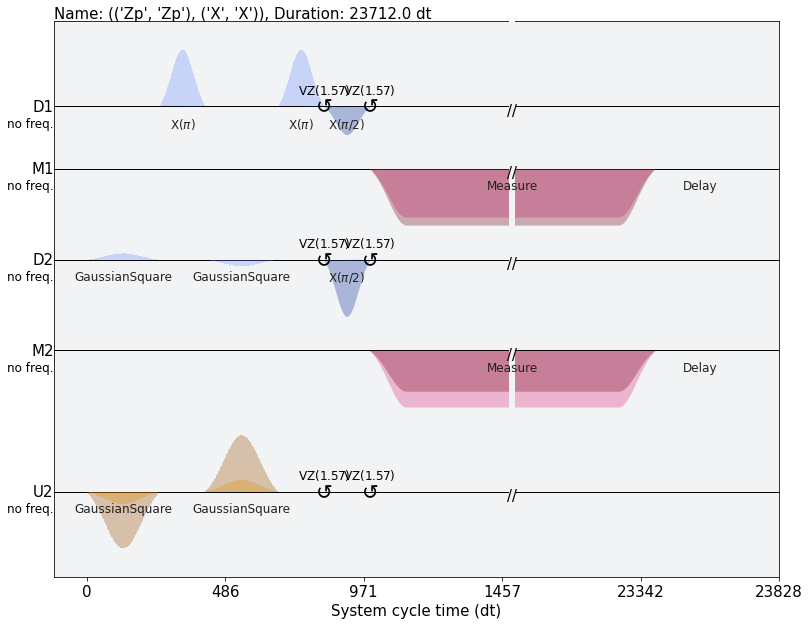

In [37]:
qpt_experiments['0.1']['qpt_schedules'][0].draw()

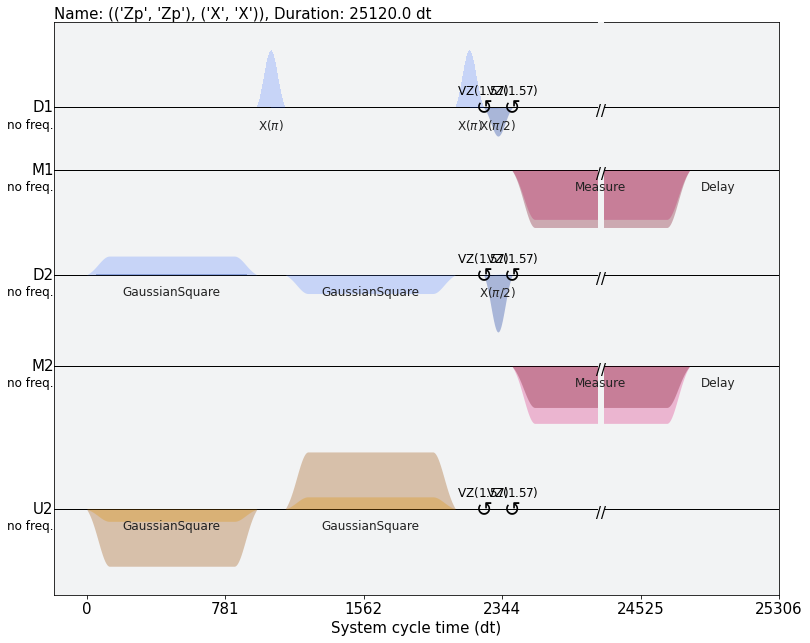

In [38]:
qpt_experiments['1.57']['qpt_schedules'][0].draw()

In [47]:
results = {}

for angle in angles:
    qpt_sched = qpt_experiments[str(angle)]['qpt_schedules']
    job = execute(qpt_sched, backend=backend, shots=512)
    result = job.result()
    results[f'{angle}'] = result

/home/laura/.local/lib/python3.9/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [48]:
label='bogota.may.20'

In [49]:
with open(f'results.{label}.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
fidelities = {}
q2 = QuantumRegister(2)

for angle in angles:
   
    qpt_circuits = qpt_experiments[str(angle)]['transpiled_circuits']
    res = results[str(angle)]
    
    process_data = ProcessTomographyFitter(res, qpt_circuits,meas_basis='Pauli', prep_basis='Pauli')
    choi_fit = process_data.fit( method='cvx', standard_weights=True,kwargs={ "trace_preserving":True, "PSD": True})
    choi_fit = choi_fit.data
   
    ideal_circ = QuantumCircuit(q2)
    ideal_circ.rzx(angle,q2[0],q2[1])
    ideal=qi.Operator(ideal_circ)
    fid = qi.average_gate_fidelity(channel=Choi(choi_fit),target=Operator(ideal.data))
    fidelities[str(angle)] = fid

In [51]:
fidelities

{'0.1': 0.9414734651142599,
 '0.5': 0.9299676969160728,
 '1.57': 0.9343375549326136}